In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [10]:
def plotOne(img1, title1, cmap1=None):
    plt.imshow(img1, cmap=cmap1)
    plt.title(title1, fontsize=20)
    plt.show()
    return

def plotMany(nrows, ncols, images, titles, cmaps):
    f, axes = plt.subplots(nrows, ncols, figsize=(20, 10))
    if nrows == 1 or ncols == 1:
        for idx, img in enumerate(images):
            axes[idx].imshow(img, cmap=cmaps[idx])
            axes[idx].set_title(titles[idx], fontsize=20) 
    else:
        c = 0
        for idx, img in enumerate(images):
            r = idx//ncols
            axes[r,c].imshow(img, cmap=cmaps[idx])
            axes[r,c].set_title(titles[idx], fontsize=20)
            c = (idx + 1) % ncols        
    plt.tight_layout()
    plt.show()
    return

def plotTwo(img1, img2, title1, title2, cmap1=None, cmap2=None):
    plotMany(1, 2, [img1,img2], [title1,title2], [cmap1,cmap2])
    return

def plotStacked(img1, img2, combined, title1, title2):
    # Stack each channel to view contributions
    stacked = np.dstack((np.zeros_like(img1), img1, img2))
    plotTwo(stacked, combined, title1, title2, None, 'gray')

In [11]:
def applyThreshold(binary, thresh):
    # Apply the threshold
    binary_th = np.zeros_like(binary)
    binary_th[(binary >= thresh[0]) & (binary <= thresh[1])] = 1
    return binary_th

def applyThresholdSobelAbs(img, orient, sobel_kernel, thresh):
    # Calculate the directional gradient
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    return applyThreshold(scaled_sobel, thresh)

def applyThresholdSobelMag(img, sobel_kernel, thresh):
    # Calculate gradient magnitude
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelxy = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    return applyThreshold(scaled_sobel, thresh)

def applyThresholdSobelDir(img, sobel_kernel, thresh):
    # Calculate gradient direction
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.sqrt(np.square(sobelx))
    abs_sobely = np.sqrt(np.square(sobely))
    dir_sobel = np.arctan2(abs_sobely, abs_sobelx)
    return applyThreshold(dir_sobel, thresh)

def applyThresholdSaturation(img, thresh):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    return applyThreshold(s_channel, thresh)

def applyAllThresholds(img, kSize, thresh, threshDir, threshS):
    gradx = applyThresholdSobelAbs(img, 'x', kSize, thresh)
    grady = applyThresholdSobelAbs(img, 'y', kSize, thresh)
    magB = applyThresholdSobelMag(img, kSize, thresh)
    dirB = applyThresholdSobelDir(img, kSize, threshDir)
    satB = applyThresholdSaturation(img, threshS)
    return gradx, grady, magB, dirB, satB 


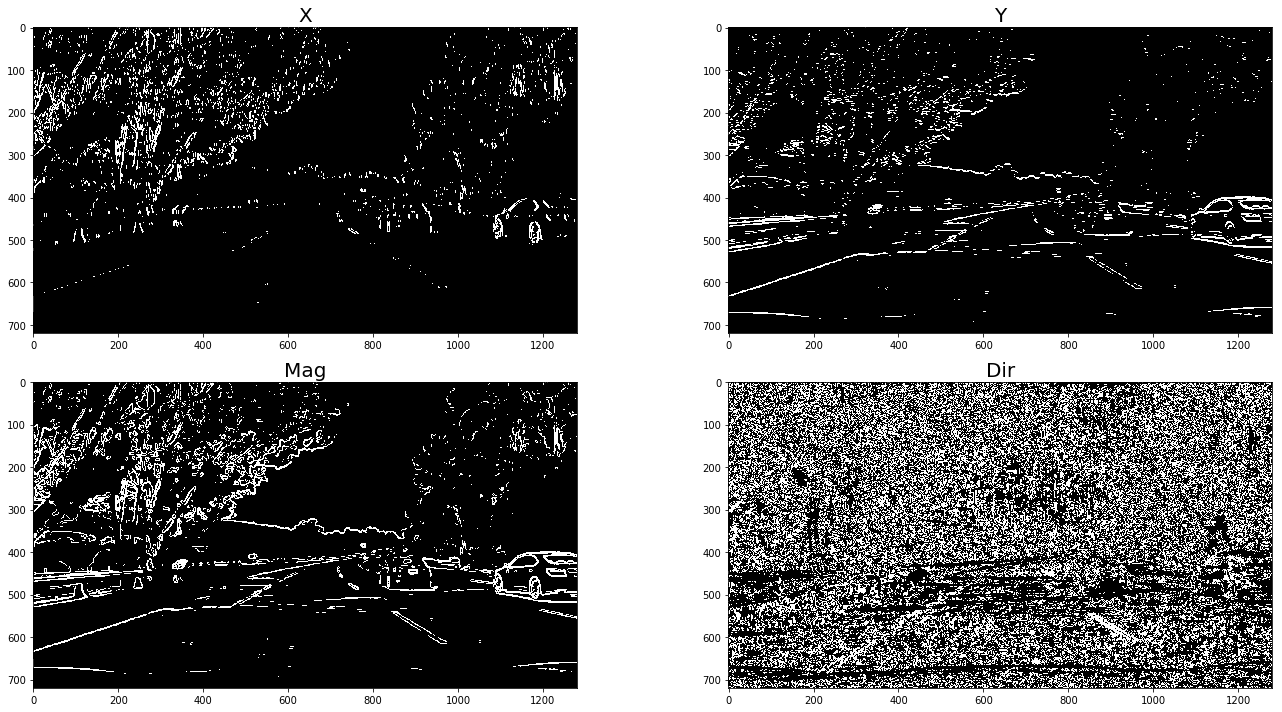

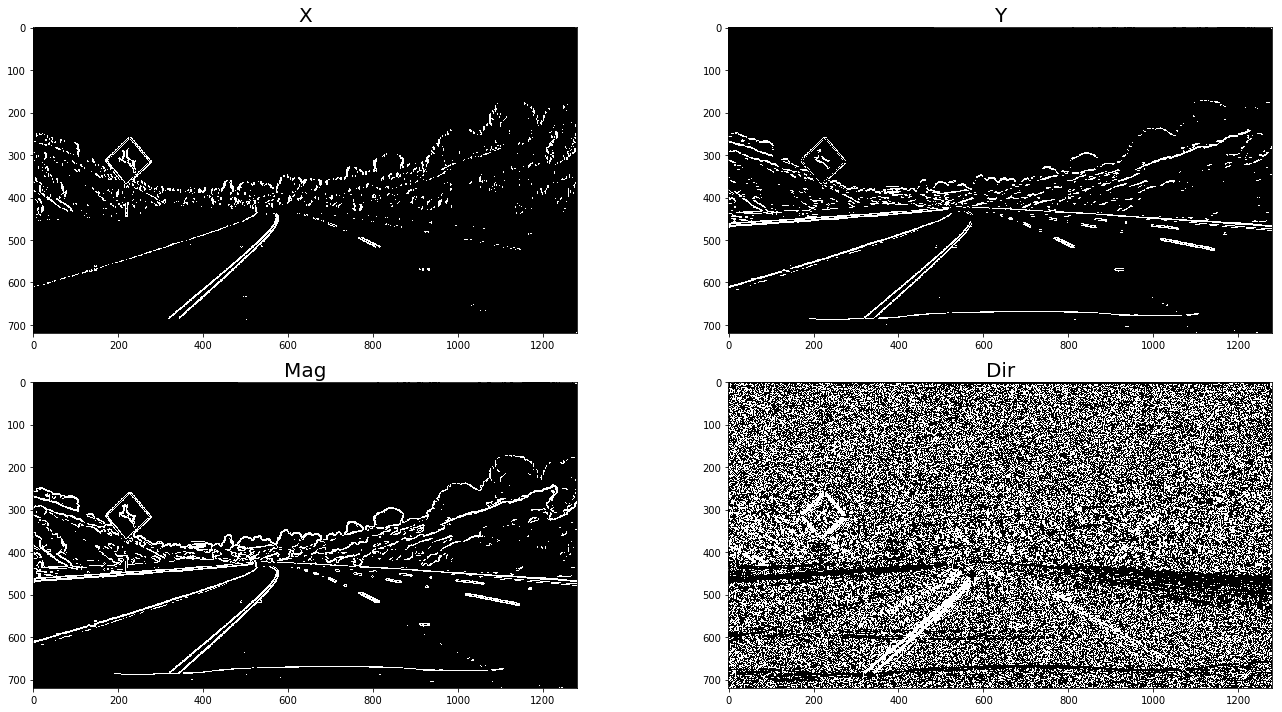

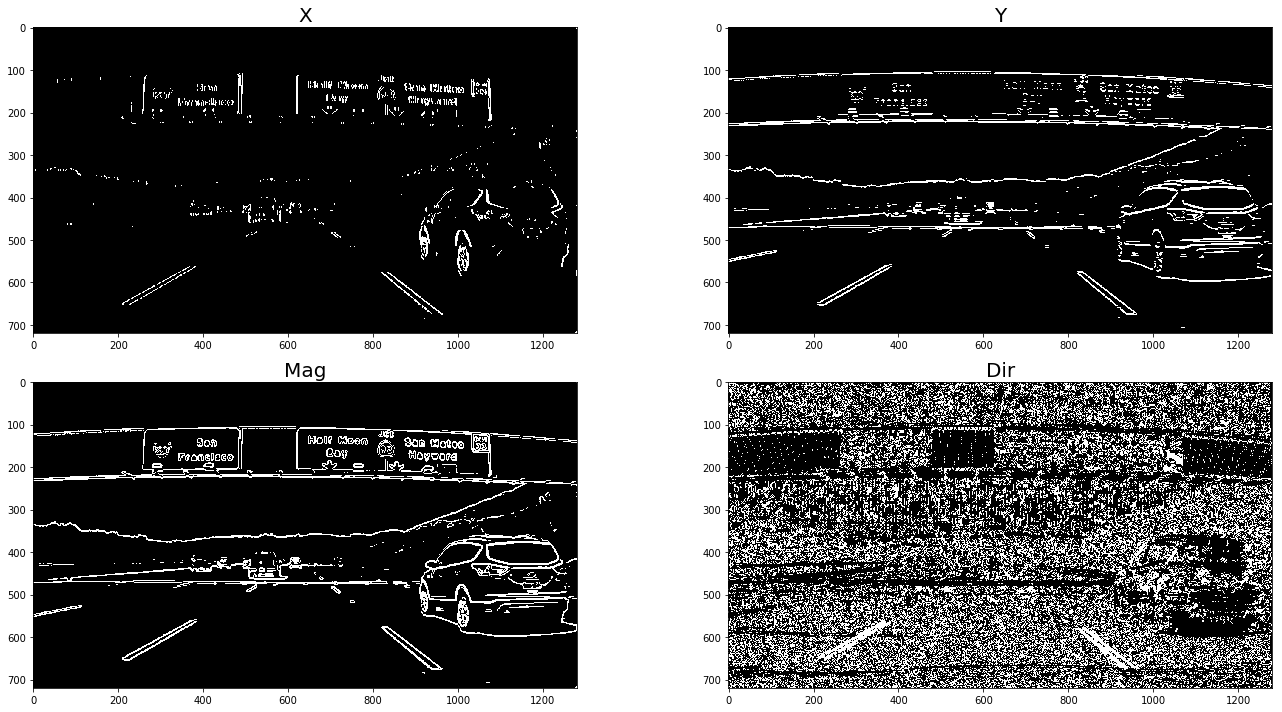

In [12]:
# Read in an image
images = []
images.append(mpimg.imread('test_images/test5.jpg'))
images.append(mpimg.imread('test_images/test2.jpg'))
images.append(mpimg.imread('signs_vehicles_xygrad.jpg'))

kSize = 9
thresh = (50,255)
threshDir = (0.5, 1.2)
threshS = (170,255)

for img in images:
    gradx, grady, magB, dirB, satB = applyAllThresholds(img, 
                                                        kSize,
                                                        thresh, 
                                                        threshDir, 
                                                        threshS)
    plotMany(2, 2, [gradx,grady,magB,dirB],
         ['X','Y','Mag','Dir'],
         ['gray','gray','gray','gray'])

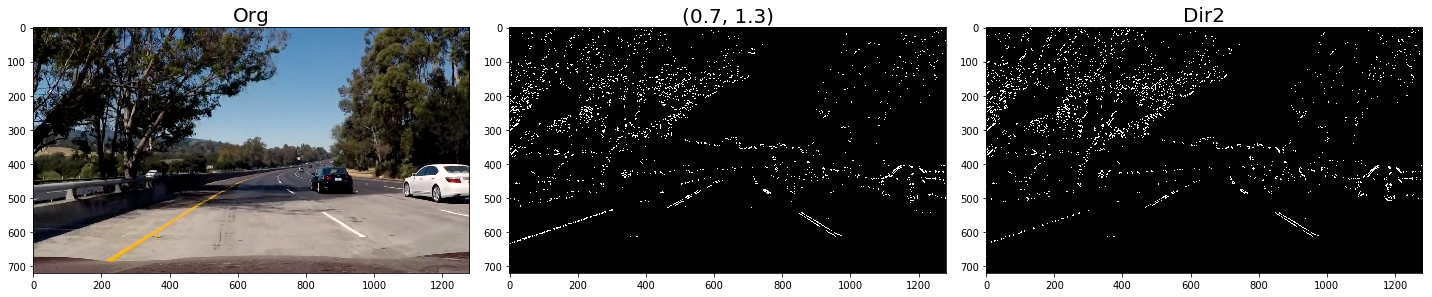

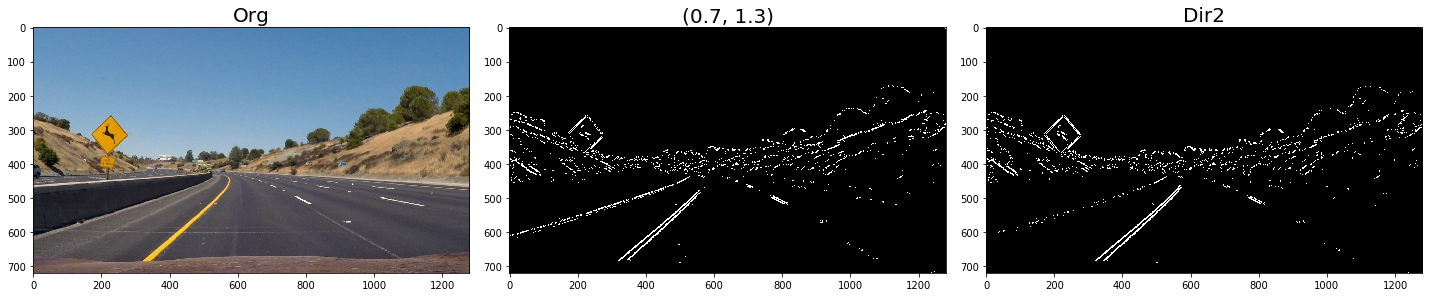

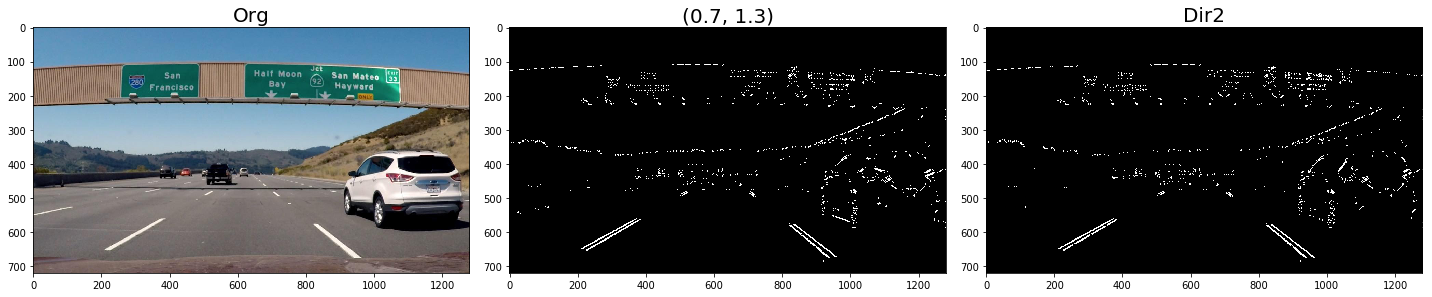

In [13]:
for img in images:
    gradx, grady, magB, dirB1, satB = applyAllThresholds(img, 
                                                        kSize,
                                                        thresh,
                                                        (0.7,1.3),
                                                        threshS)   
    c1 = np.zeros_like(dirB1)
    c1[((magB == 1) & (dirB1 == 1))] = 1
    
    dirB2 = applyThresholdSobelDir(img, kSize, (0.5, 1.2))
    c2 = np.zeros_like(dirB2)
    c2[((magB == 1) & (dirB2 == 1))] = 1
    
    plotMany(1, 3, [img, c1, c2], ['Org','(0.7, 1.3)', 'Dir2'], 
             [None, 'gray','gray'])

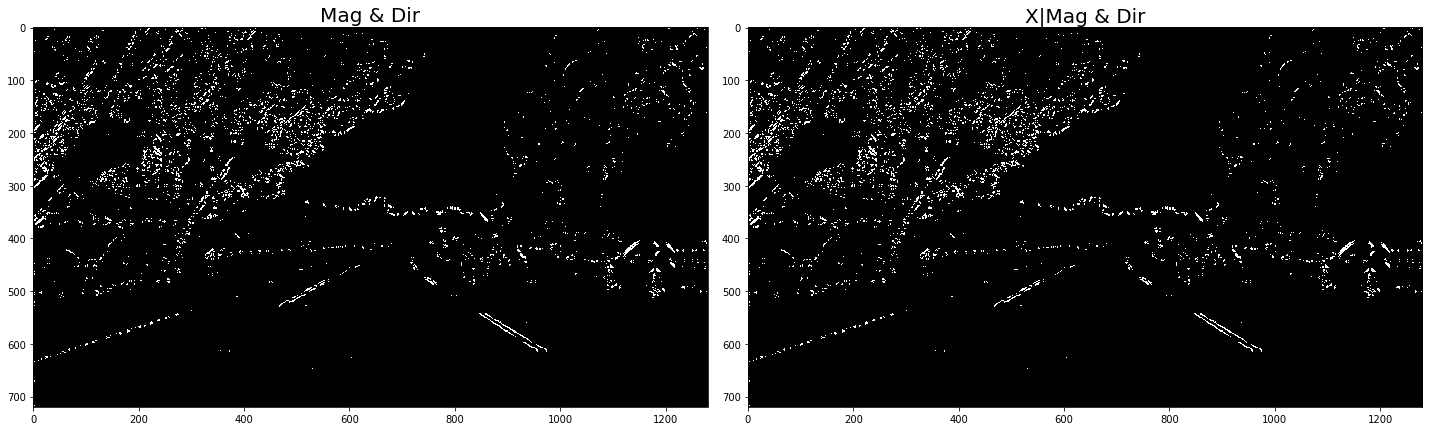

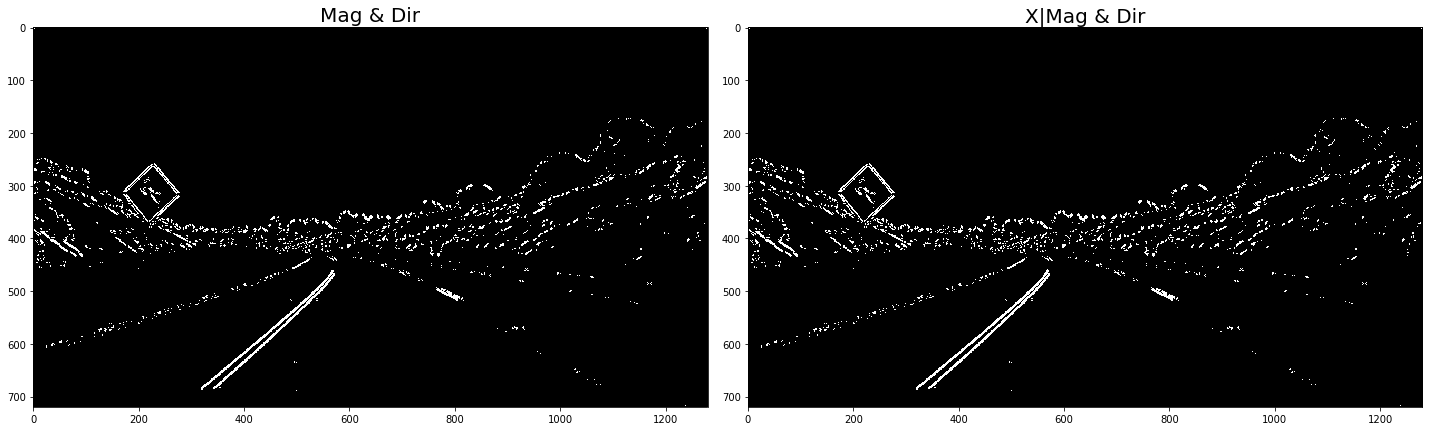

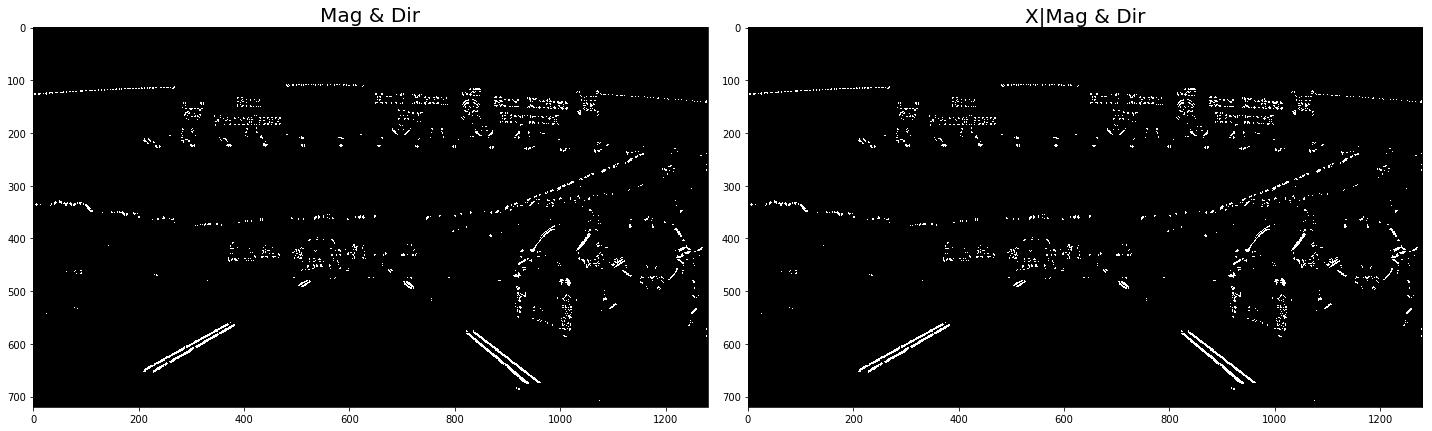

In [14]:
for img in images:
    gradx, grady, magB, dirB, satB = applyAllThresholds(img, 
                                                        kSize,
                                                        thresh,
                                                        threshDir,
                                                        threshS)   
    c1 = np.zeros_like(dirB)
    c1[((gradx == 1)&(grady == 1))|((magB == 1)&(dirB == 1))] = 1
    
    c2 = np.zeros_like(dirB)
    c2[((magB == 1) & (dirB == 1))] = 1
    
    c3 = np.zeros_like(dirB)
    c3[(((gradx == 1) | (magB == 1)) & (dirB == 1))] = 1
    
    plotMany(1, 2, [c2, c3], 
             ['Mag & Dir', 'X|Mag & Dir'], 
             ['gray','gray'])
    
#    plotMany(2, 2, [img, c1, c2, c3], 
#             ['Org', 'X & Y | mag & dir', 'Mag & Dir', 'X|Mag & dir'], 
#             [None, 'gray','gray','gray'])


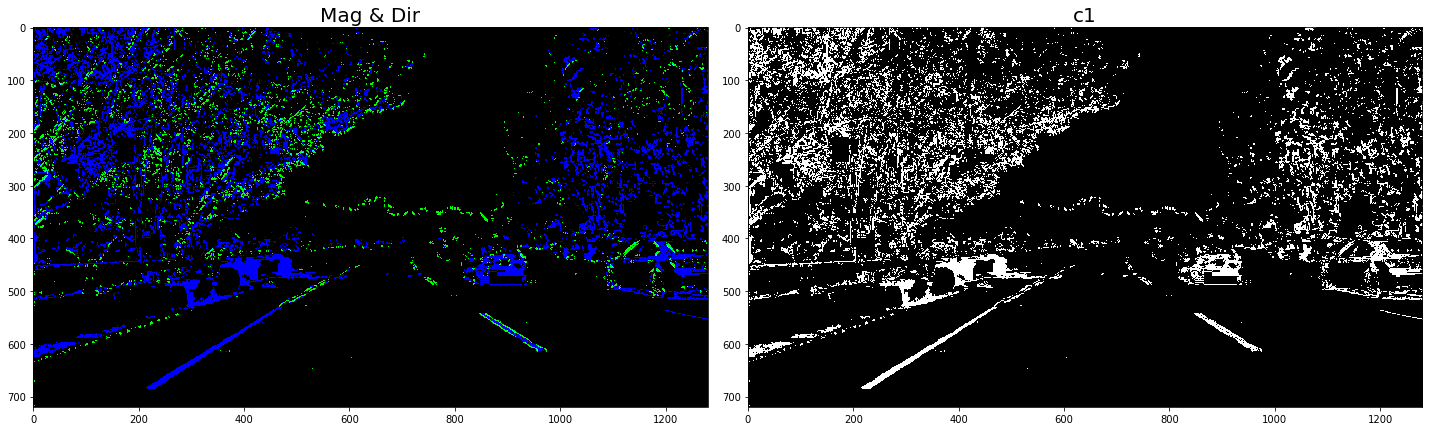

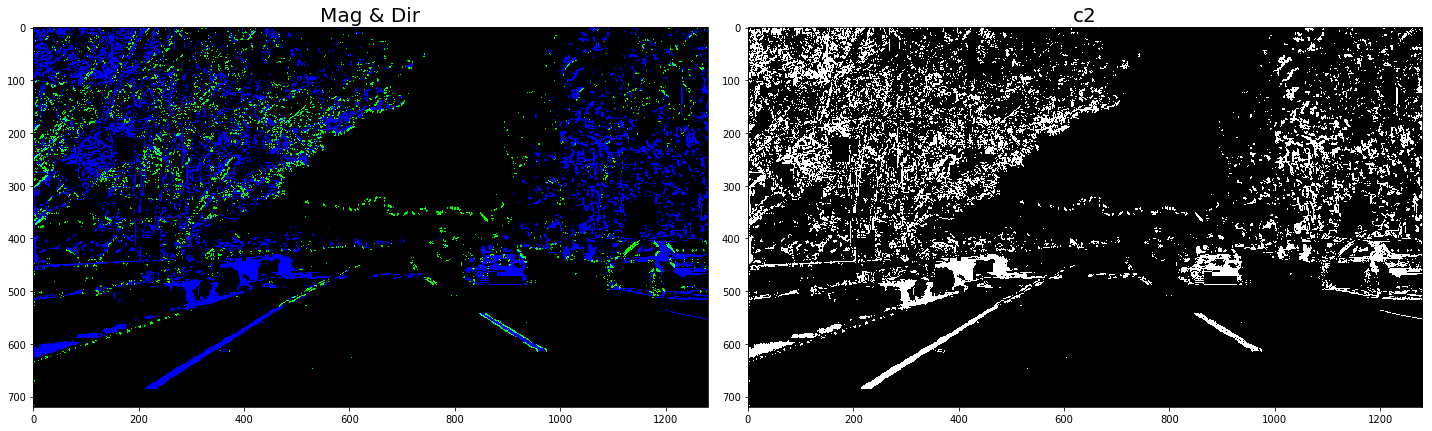

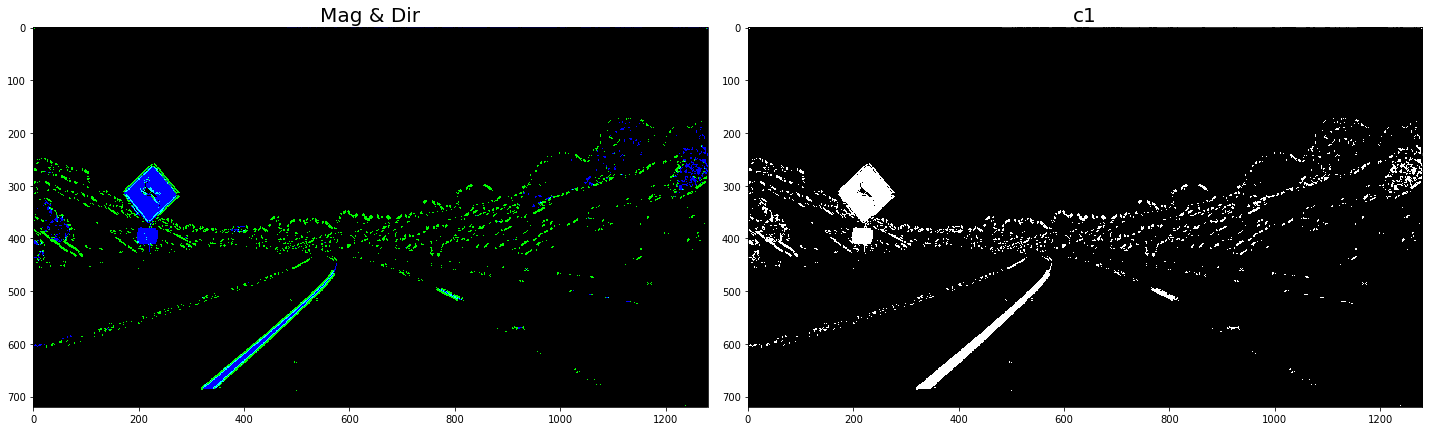

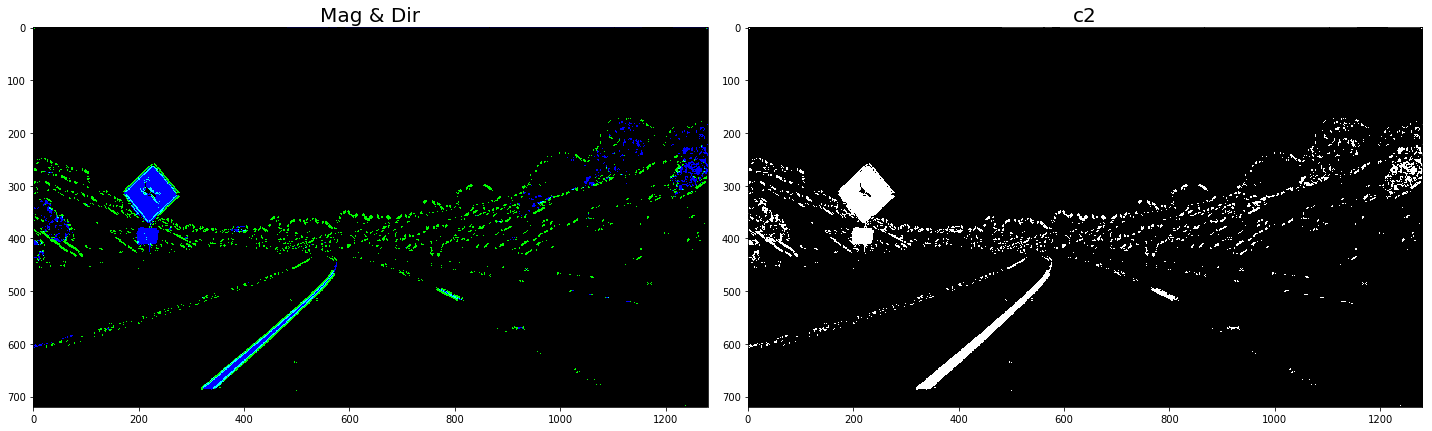

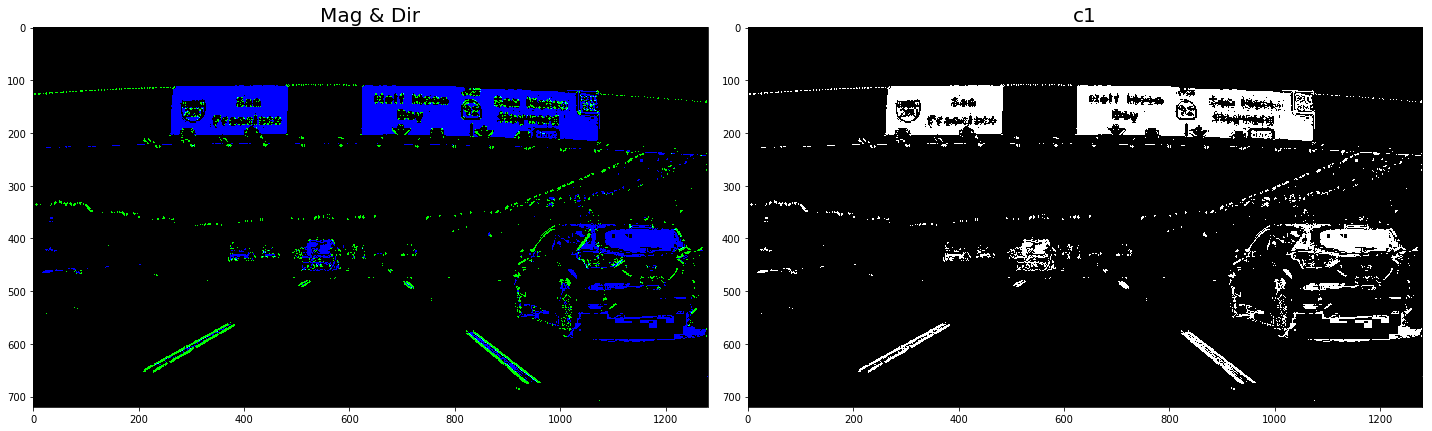

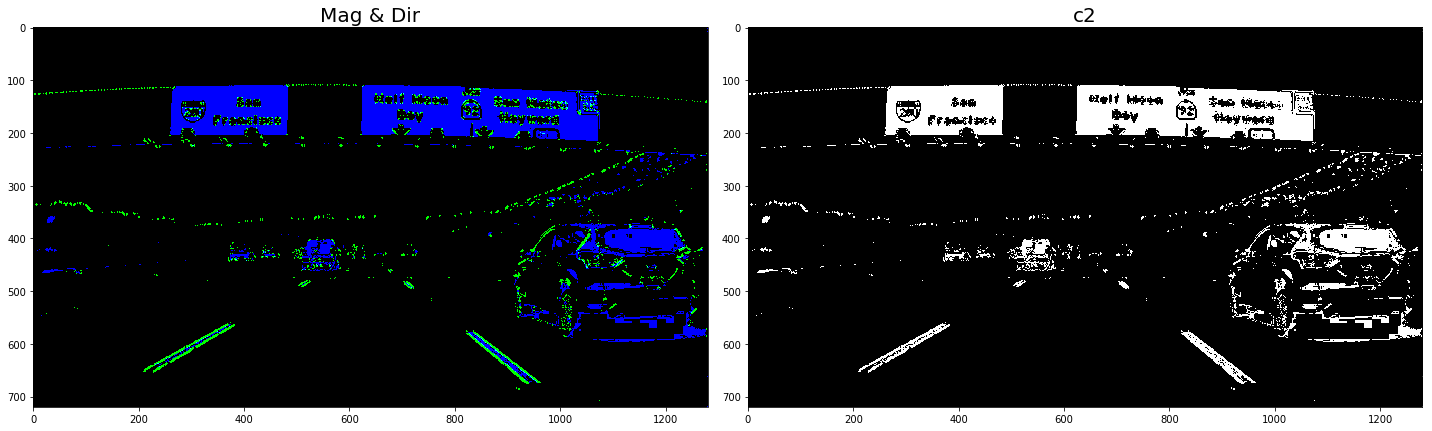

In [17]:
for img in images:
    gradx, grady, magB, dirB, satB1 = applyAllThresholds(img, 
                                                        kSize,
                                                        thresh,
                                                        threshDir,
                                                        (170,255))   
    opt1 = np.zeros_like(dirB)
    opt1[((magB == 1) & (dirB == 1))] = 1    
   
    c1 = np.zeros_like(dirB)
    c1[(satB1 == 1) | (opt1 == 1)] = 1 
    plotStacked(opt1, satB1, c1, 'Mag & Dir', 'c1')
    
    satB2 = applyThresholdSaturation(img, (150,255))
    c2 = np.zeros_like(dirB)
    c2[(satB2 == 1) | (opt1 == 1)] = 1  
    plotStacked(opt1, satB2, c2, 'Mag & Dir', 'c2')